# 208 Check fair neg
In this notebook, we will construct a scenario with additional cumulative negative emissions of -1060 GtCO2 or so, and run this through FaIR to see what happens.  

In [1]:
import os
import json
import copy
import pyam
import pandas as pd

from climate_assessment.climate.fair import get_fair_configurations
from climate_assessment.climate import clean_wg3_scenarios
from utils import construct_new_floor_pathway

from scmdata import ScmRun
from openscm_runner.run import run
from openscm_runner.adapters import FAIR

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

<IPython.core.display.Javascript object>

/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


Step 1: Read in the emission estimates generated in notebook `203_prepare_ren_emission_data.ipynb`

In [2]:
df = pyam.IamDataFrame(
    Path(
        'processed_data/203_ren_emissions.csv'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file processed_data/203_ren_emissions.csv


Step 2: Filter out a "starting" scenario that we will build on.

In [3]:
df_starter = (
    df
    .filter(
        scenario='Ren_NZCO2_5'
    )
)

In [4]:
df_starter.convert_unit(
    current='Mt CO2/yr',
    to='Gt CO2/yr',
    inplace=True
)

Step 3: Construct the new floor pathway.

In [5]:
new_floor_pathways, cumulative = (
    construct_new_floor_pathway(
        df_starter,
        'Emissions|CO2|Energy and Industrial Processes',
        -26.5
    )
)
cumulative

-1072.5973018999994

Step 4: Manage the variable naming to run through the WG3 cleaning function.

In [6]:
new_floor_ts = (
    new_floor_pathways
    .timeseries()
    .reset_index()
)

In [7]:
new_floor_ts['variable'] = (
    new_floor_ts['variable']
    .apply(
        lambda x: x.replace(
            'Emissions',
            'Infilled|Emissions'
        )
    )
)

Step 5: Run this through the cleaning function

In [8]:
new_floor_cleaned = clean_wg3_scenarios(
    pyam.IamDataFrame(
        new_floor_ts
    )
)

/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Step 6: Rename the variable.

In [9]:
new_floor_cleaned.loc[:,'variable'] = (
    new_floor_cleaned.loc[:,'variable']
    .apply(
        lambda x: x.replace(
            'Infilled|Emissions',
            'Emissions'
        )
    )
)

Step 7: Cast this to an ScmRun dataframe

In [10]:
new_floor_scmrun = ScmRun(
    new_floor_cleaned
)

Step 8: Load the FaIR configurations

In [11]:
data_dir = os.path.join('processed_data', 'fair')
fair_slim_filename = 'fair-1.6.2-wg3-params-slim.json'
fair_common_filename = 'fair-1.6.2-wg3-params-common.json'

In [12]:
fair_config = get_fair_configurations(
    fair_version='1.6.2',
    fair_probabilistic_file=os.path.join(data_dir, fair_slim_filename),
    fair_extra_config=os.path.join(data_dir, fair_common_filename),
    num_cfgs=2237
)

Step 9: Trim the length of the configuration

In [13]:
nt = new_floor_scmrun.time_points.years()[-1] - 1750 + 1
nt

361

In [14]:
updated_config = copy.deepcopy(fair_config)
for i in range(len(fair_config)):
    updated_config[i]['F_solar'] = updated_config[i]['F_solar'][:nt]
    updated_config[i]['F_volcanic'] = updated_config[i]['F_volcanic'][:nt]
    updated_config[i]['natural'] = updated_config[i]['natural'][:nt]

Step 10: Run FaIR

In [15]:
temp = run(
    climate_models_cfgs={
        'FAIR':updated_config
    },
    scenarios=new_floor_scmrun,
    output_variables=(
        "Surface Air Temperature Change",
    ),
)

Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

Creating FaIR emissions inputs:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

scmdata.run - INFO: Reading /Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/openscm_runner/adapters/fair_adapter/rcmip-emissions-annual-means-v5-1-0-historical-ssp245.csv
/Users/gauravganti/opt/anaconda3/envs/provide_perspective/lib/python3.10/site-packages/openscm_units/_unit_registry.py:471: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for label, val in metric_conversion.iteritems():
dotenv.main - INFO: Python-dotenv could not find configuration file .env.
openscm_runner.adapters.fair_adapter._run_fair - INFO: Running FaIR with 8 workers


Front serial:   0%|          | 0.00/3.00 [00:00<?, ?it/s]

Front parallel:   0%|          | 0.00/2.00 [00:00<?, ?it/s]

Parallel runs:   0%|          | 0.00/2.23k [00:00<?, ?it/s]

openscm_runner.run - INFO: Only one model run, returning its results


Step 11: Rebase the output

In [16]:
temp_rebased = (
    temp
    .relative_to_ref_period_mean(
        year=range(
            1850,
            1901
        )
    )
)

In [17]:
temp_ts = (
    temp_rebased
    .to_iamdataframe()
    .swap_time_for_year()
    .filter(
        year=range(2000, 2101)
    )
    .timeseries()
)

Step 12: Make a plot with the warming outcomes that we will use in the Supplementary Material.

Text(0, 0.5, 'Temperature [°C relative to 1850-1900 mean]')

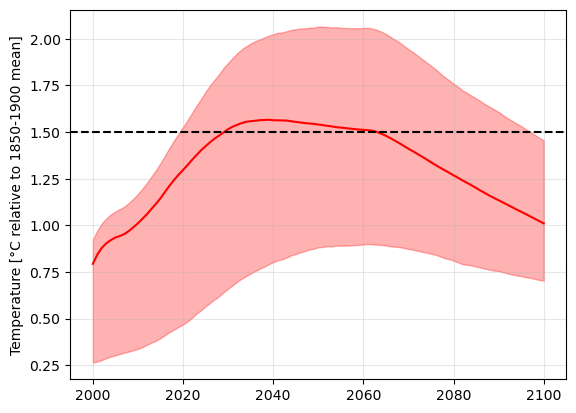

In [18]:
fig,ax = plt.subplots()

temp_ts.median().plot(ax=ax, color='red')
ax.fill_between(
    x=temp_ts.columns,
    #y1=temp_ts.quantile(q=0.75),
    #y2=temp_ts.quantile(q=0.75)-temp_ts.quantile(q=0.25),
    y1=temp_ts.quantile(q=0.95),
    y2=temp_ts.quantile(q=0.95)-temp_ts.quantile(q=0.05),
    alpha=0.3,
    color='red'
)
ax.axhline(1.5, color='black', linestyle='dashed')
ax.grid(alpha=0.3)
ax.set_ylabel(
    'Temperature [°C relative to 1850-1900 mean]'
)

In [19]:
fig.savefig(
    Path(
        'figures/SI_fig3.png'
    ),
    dpi=400,
    bbox_inches='tight'
)